**Использумые библиотеки**

In [1]:
import pandas as pd
import requests
import urllib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, levene
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

**1. Подготовка данных**

In [2]:
# Скачивание csv-файлов с яндекс.диска
def download_from_yadisk(public_url: str, filename: str):
    api_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
    params = {"public_key": public_url}

# Получаем загрузочную ссылку
    response = requests.get(api_url, params=params)
    if response.status_code == 200:
        download_url = response.json().get('href')
        if not download_url:
            print(f"Ошибка: не получили ссылку на скачивание для {filename}")
            return
        
# Загружаем файл и сохраняем его
        file_response = requests.get(download_url)
        if file_response.status_code == 200:
            with open(filename, "wb") as f:
                f.write(file_response.content)
            print(f"Файл '{filename}' успешно скачан!")
        else:
            print(f"Ошибка при скачивании файла '{filename}': {file_response.status_code}")
    else:
        print(f"Ошибка при получении ссылки для скачивания '{filename}': {response.status_code}")


files = {
    "https://disk.yandex.ru/d/UhyYx41rTt3clQ": "Проект_2_groups.csv",
    "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ": "Проект_2_group_add.csv",
    "https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ": "Проект_2_active_studs.csv",
    "https://disk.yandex.ru/d/pH1q-VqcxXjsVA": "Проект_2_checks.csv",
}

for url, filename in files.items():
    download_from_yadisk(url, filename)

Файл 'Проект_2_groups.csv' успешно скачан!
Файл 'Проект_2_group_add.csv' успешно скачан!
Файл 'Проект_2_active_studs.csv' успешно скачан!
Файл 'Проект_2_checks.csv' успешно скачан!


In [3]:
# Чтение данных из csv-файлов
groups = pd.read_csv("Проект_2_groups.csv", sep=';')
groups_add = pd.read_csv("Проект_2_group_add.csv")
active = pd.read_csv("Проект_2_active_studs.csv")
checks = pd.read_csv("Проект_2_checks.csv", sep=';')

In [4]:
# Объединение групп
groups_all = pd.concat([groups, groups_add], ignore_index=True)

# Переименование колонок
groups.rename(columns={'id': 'student_id', 'grp': 'group'}, inplace=True)
groups_add.rename(columns={'id': 'student_id', 'grp': 'group'}, inplace=True)

# Объединение и удаление дубликатов
groups_all = pd.concat([groups, groups_add], ignore_index=True)
groups_all = groups_all.drop_duplicates(subset='student_id')

In [5]:
# Проверка на баги
paid_users = set(checks['student_id'].unique())
active_users = set(active['student_id'].unique())

# Пользователи, которые оплатили, но не были активны
paid_not_active = paid_users - active_users
print(f"Пользователи, оплатившие, но не активные: {len(paid_not_active)}")

Пользователи, оплатившие, но не активные: 149


In [6]:
# Исключаем таких пользователей из анализа
checks = checks[checks['student_id'].isin(active_users)]

if len(paid_not_active):
    print(f"Оплатившие, но не активные пользователи удалены")

Оплатившие, но не активные пользователи удалены


In [7]:
# Оставляем только активных пользователей с группами
active_all = active.merge(groups_all, on='student_id')

# Присоединяем оплаты (left join — чтобы все активные остались, даже без оплаты)
data = active_all.merge(checks[['student_id', 'rev']], on='student_id', how='left')
# Заполняем отсутствующие оплаты нулями — это важно для ARPU
data['rev'] = data['rev'].fillna(0)

data.head(3)

,student_id,group,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0


**2. Расчет метрик**

**Метрики, которые нужно расчитать:**

  1. **CR** (Conversion Rate) — Конверсия

**Что измеряет:** долю пользователей, совершивших оплату из числа всех активных.

**Почему важна:** это первая точка контакта с монетизацией. Даже если ARPU и ARPPU высокие, но CR падает слишком сильно — это означает потерю пользователей.

Данная метрика показывает, насколько изменение повлияло на мотивацию платить вообще.

  2. **ARPU** (Average Revenue Per User) — Средний доход на одного пользователя

**Что измеряет:** сумму выручки, делённая на всех активных пользователей (включая тех, кто не платил).

**Почему важна:** это основная бизнес-метрика, особенно если цель — увеличить доход на пользователя.

  3. **ARPPU** (Average Revenue Per Paying User) — Средний доход на одного плательщика

**Что измеряет:** сумму выручки, делённая на число плательщиков.

**Почему важна:** помогает понять, качество продаж: платят больше или просто больше людей платит?

In [8]:
# Группировка по группам
metrics = data.groupby('group').agg(
    n_users=('student_id', 'nunique'),
    payers=('rev', lambda x: (x > 0).sum()),
    revenue=('rev', 'sum')
).reset_index()

# Расчет метрик
metrics['CR'] = metrics['payers'] / metrics['n_users']
metrics['ARPU'] = metrics['revenue'] / metrics['n_users']
metrics['ARPPU'] = metrics['revenue'] / metrics['payers']

metrics

,group,n_users,payers,revenue,CR,ARPU,ARPPU
0,A,1538,78.0,72820.0000,0.050715,47.347204,933.589744
1,B,6803,314.0,394974.0035,0.046156,58.058798,1257.878992


**3. Визуализация полученных метрик**

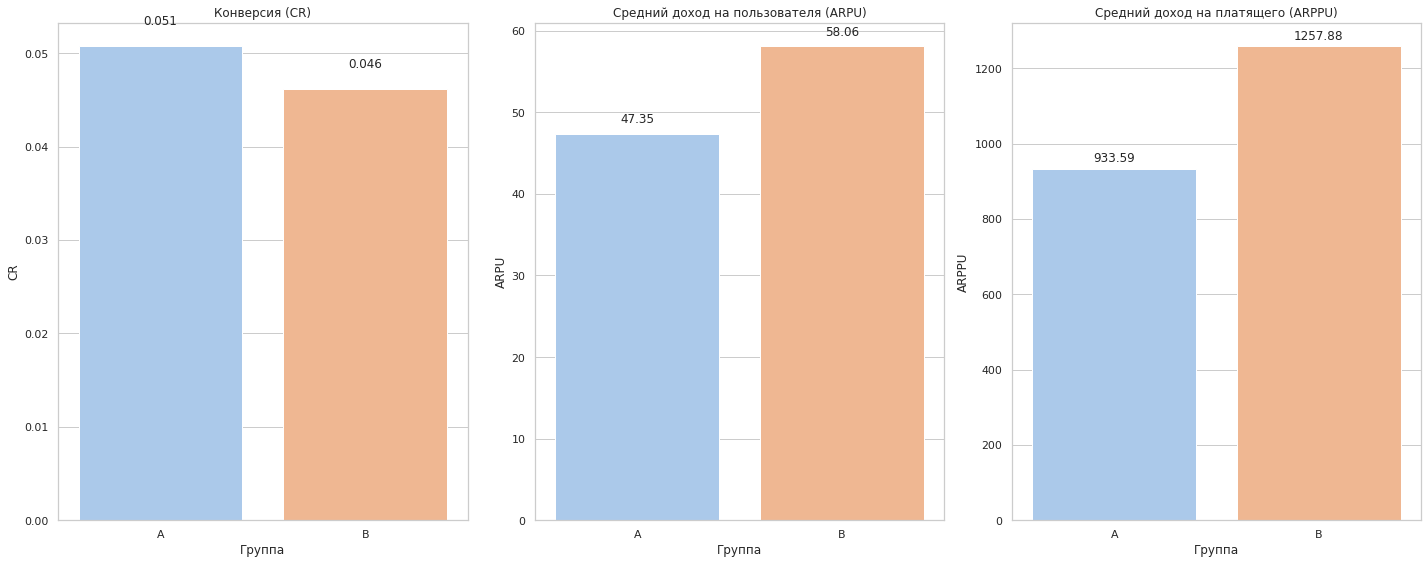

In [9]:
# Установка стиля
sns.set(style="whitegrid")

# Создание графика с подписями данных
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# График CR
sns.barplot(x='group', y='CR', data=metrics, ax=axs[0], palette='pastel')
axs[0].set_title('Конверсия (CR)')
axs[0].set_xlabel('Группа')
axs[0].set_ylabel('CR')
for i, row in metrics.iterrows():
    axs[0].text(i, row['CR'] + 0.002, f"{row['CR']:.3f}", ha='center', va='bottom')

# График ARPU
sns.barplot(x='group', y='ARPU', data=metrics, ax=axs[1], palette='pastel')
axs[1].set_title('Средний доход на пользователя (ARPU)')
axs[1].set_xlabel('Группа')
axs[1].set_ylabel('ARPU')
for i, row in metrics.iterrows():
    axs[1].text(i, row['ARPU'] + 1, f"{row['ARPU']:.2f}", ha='center', va='bottom')

# График ARPPU
sns.barplot(x='group', y='ARPPU', data=metrics, ax=axs[2], palette='pastel')
axs[2].set_title('Средний доход на платящего (ARPPU)')
axs[2].set_xlabel('Группа')
axs[2].set_ylabel('ARPPU')
for i, row in metrics.iterrows():
    axs[2].text(i, row['ARPPU'] + 10, f"{row['ARPPU']:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Интерпретация графиков:**

- Конверсия в группе B ниже, чем в A. Это может быть тревожным сигналом, если основной KPI — CR.

- ARPU выше в группе B, то есть, несмотря на более низкую конверсию, каждый пользователь в среднем приносит больше.

- ARPPU (средний доход на платящего пользователя): среди тех, кто платит, группа B показывает заметно выше доход, чем A.


**Предварительные выводы:**

Экспериментальная группа B может привлекать более платежеспособных пользователей.

Однако снижение конверсии должно быть проанализировано глубже: возможно, изменение отпугивает часть пользователей.

Стоит проверить статистическую значимость разницы.

**4. Проверка нормальности и дисперсий**

*4.1 Проверка нормальности*

H₀ (нулевая гипотеза): распределение выборки нормальное.

H₁ (альтернативная гипотеза): распределение выборки отличается от нормального.

In [10]:
# Определяем значения для теста нормальности
arpu_A = data[data['group'] == 'A']['rev']
arpu_B = data[data['group'] == 'B']['rev']
arppu_A = data[(data['group'] == 'A') & (data['rev'] > 0)]['rev']
arppu_B = data[(data['group'] == 'B') & (data['rev'] > 0)]['rev']

# Проверка нормальности 
stat_a, p_a = shapiro(arpu_A)
stat_b, p_b = shapiro(arpu_B)
print(f"Нормальность ARPU — A: p={p_a:.4f}, B: p={p_b:.4f}")

stat_a, p_a = shapiro(arppu_A)
stat_b, p_b = shapiro(arppu_B)
print(f"Нормальность ARPPU — A: p={p_a:.4f}, B: p={p_b:.4f}")


Нормальность ARPU — A: p=0.0000, B: p=0.0000
Нормальность ARPPU — A: p=0.0000, B: p=0.0000


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Выводы по нормальности**:

Т.К. p-value < 0.05, **отклоняем H₀ о нормальном распределении**.

То есть, распределения ARPU/ARPPU сильно отличаются от нормальных (скорее всего, правосторонне скошены, что нормально для данных по выручке).

Это значит, что t-тест можно применять только как приближение, но лучше проверить непараметрическим методом (Mann–Whitney) или через бутстрап.

*4.2 Проверка равенства дисперсий*

H₀: дисперсии в двух группах равны.

H₁: дисперсии в двух группах различаются.

In [11]:
# Проверка равенства дисперсий
stat_var, p_var = levene(arpu_A, arpu_B)
print(f"Равенство дисперсий ARPU: p={p_var:.4f}")

Равенство дисперсий ARPU: p=0.2205


**Выводы дисперсии**:

Т.к. p-value > 0.05, **нет статистически значимых различий дисперсий между группами**.

Даже при равных дисперсиях t-тест на таких данных может давать искажённые p-values из-за выбросов.
А Манн–Уитни и бутстрап к этому гораздо устойчивее.

**5. Статистические тесты**

Формулировка гипотез:

**H₀ (нулевая гипотеза):** Конверсия (или средний чек — в зависимости от метрики) в группах A и B одинакова.  

**H₁ (альтернативная гипотеза):** Конверсия (или средний чек) в группе B отличается от группы A.

In [12]:
#z-тест для для CR
successes = [
    data[(data['group'] == 'A') & (data['rev'] > 0)].shape[0],
    data[(data['group'] == 'B') & (data['rev'] > 0)].shape[0]
]
nobs = [
    data[data['group'] == 'A'].shape[0],
    data[data['group'] == 'B'].shape[0]
]
z_stat, pval_cr = proportions_ztest(count=successes, nobs=nobs)

#t-тест для ARPU и ARPPU
t_arpu, pval_arpu = ttest_ind(arpu_A, arpu_B, equal_var=False)
t_arppu, pval_arppu = ttest_ind(arppu_A, arppu_B, equal_var=False)

# Mann–Whitney для ARPU и ARPPU
u_arpu, p_mw_arpu = mannwhitneyu(arpu_A, arpu_B, alternative='two-sided')
u_arppu, p_mw_arppu = mannwhitneyu(arppu_A, arppu_B, alternative='two-sided')

# Итоговые выводы
print("\nP-value по метрикам:")
print(f"CR:       p-value       z-test = {pval_cr:.6f}")
print(f"ARPU:     p-value Mann–Whitney = {p_mw_arpu:.6f}, t-test = {pval_arpu:.6f}")
print(f"ARPPU:    p-value Mann–Whitney = {p_mw_arppu:.6f}, t-test = {pval_arppu:.6f}")


P-value по метрикам:
CR:       p-value       z-test = 0.445470
ARPU:     p-value Mann–Whitney = 0.509975, t-test = 0.198436
ARPPU:    p-value Mann–Whitney = 0.000251, t-test = 0.005070


Shapiro–Wilk показал, что распределения далеко от нормальных **t-тест показан для справки**. Из-за ненормальности распределений основным был выбран непараметрический тест Манна–Уитни

**Выводы:**

**CR**: p-value z-test = 0.445470 (> 0.05) - **различия статистически незначимы** — гипотеза о равенстве CR между группами A и B не отвергается.

**ARPU**: p-value Mann–Whitney = 0.509975 (> 0.05) - **различия статистически незначимы** — средний доход на пользователя в группах A и B можно считать одинаковым.

**ARPPU**: p-value Mann–Whitney = 0.000251 (< 0.05) - **различия статистически значимы** — платящие пользователи группы B приносят заметно больше дохода, чем в группе A.

**6. Bootstrap**

*6.1 Расчет доверительных интрвалов*

In [13]:
def bootstrap(metric_A, metric_B, n_bootstrap=10000):
    boot_stats = []
    for _ in range(n_bootstrap):
        boot_A = np.random.choice(metric_A, size=len(metric_A), replace=True)
        boot_B = np.random.choice(metric_B, size=len(metric_B), replace=True)
        boot_stats.append(boot_B.mean() - boot_A.mean())
    return boot_stats

arpu_A = data[data['group'] == 'A']['rev'].fillna(0)
arpu_B = data[data['group'] == 'B']['rev'].fillna(0)

# Bootstrap для ARPU
boot_diff = bootstrap(arpu_A.values, arpu_B.values)
ci = np.percentile(boot_diff, [2.5, 97.5])
print(f"95% доверительный интервал разницы ARPU: {ci}")

# Bootstrap для CR
cr_A = (data[data['group'] == 'A']['rev'] > 0).astype(int)
cr_B = (data[data['group'] == 'B']['rev'] > 0).astype(int)
boot_diff_cr = bootstrap(cr_A.values, cr_B.values)
ci_cr = np.percentile(boot_diff_cr, [2.5, 97.5])
print(f"95% доверительный интервал разницы CR: {ci_cr}")

# Bootstrap для ARPPU
arppu_A_vals = arppu_A.values
arppu_B_vals = arppu_B.values
boot_diff_arppu = bootstrap(arppu_A_vals, arppu_B_vals)
ci_arppu = np.percentile(boot_diff_arppu, [2.5, 97.5])
print(f"95% доверительный интервал разницы ARPPU: {ci_arppu}")

95% доверительный интервал разницы ARPU: [-6.31575137 26.35236651]
95% доверительный интервал разницы CR: [-0.01694111  0.00733707]
95% доверительный интервал разницы ARPPU: [ 94.25130847 535.43287028]


*6.2 Визуализация распределения разниц*

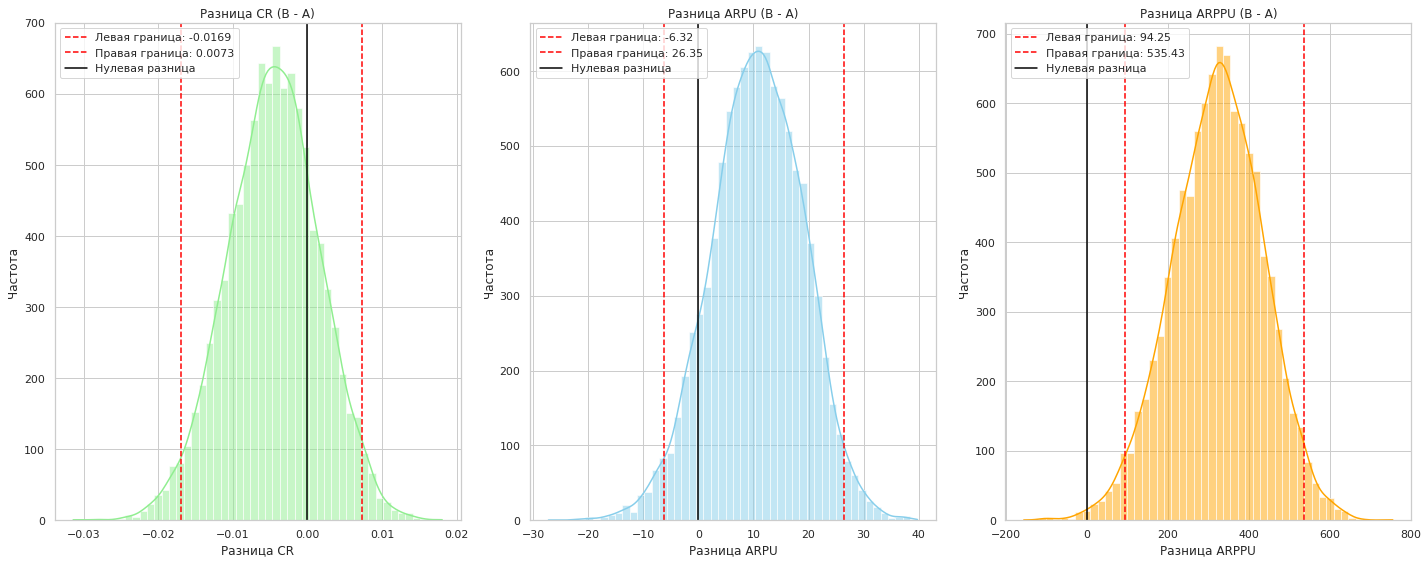

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# CR
sns.histplot(boot_diff_cr, bins=50, kde=True, color='lightgreen', ax=axes[0])
axes[0].axvline(ci_cr[0], color='red', linestyle='--', label=f'Левая граница: {ci_cr[0]:.4f}')
axes[0].axvline(ci_cr[1], color='red', linestyle='--', label=f'Правая граница: {ci_cr[1]:.4f}')
axes[0].axvline(0, color='black', linestyle='-', label='Нулевая разница')
axes[0].set_title('Разница CR (B - A)')
axes[0].set_xlabel('Разница CR')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(True)

# ARPU
sns.histplot(boot_diff, bins=50, kde=True, color='skyblue', ax=axes[1])
axes[1].axvline(ci[0], color='red', linestyle='--', label=f'Левая граница: {ci[0]:.2f}')
axes[1].axvline(ci[1], color='red', linestyle='--', label=f'Правая граница: {ci[1]:.2f}')
axes[1].axvline(0, color='black', linestyle='-', label='Нулевая разница')
axes[1].set_title('Разница ARPU (B - A)')
axes[1].set_xlabel('Разница ARPU')
axes[1].set_ylabel('Частота')
axes[1].legend()
axes[1].grid(True)

# ARPPU
sns.histplot(boot_diff_arppu, bins=50, kde=True, color='orange', ax=axes[2])
axes[2].axvline(ci_arppu[0], color='red', linestyle='--', label=f'Левая граница: {ci_arppu[0]:.2f}')
axes[2].axvline(ci_arppu[1], color='red', linestyle='--', label=f'Правая граница: {ci_arppu[1]:.2f}')
axes[2].axvline(0, color='black', linestyle='-', label='Нулевая разница')
axes[2].set_title('Разница ARPPU (B - A)')
axes[2].set_xlabel('Разница ARPPU')
axes[2].set_ylabel('Частота')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

Из графиков "Bootstrap распределение разницы CR" и "Bootstrap распределение разницы ARPU" видно, что левая граница интервала меньше 0, а правая больше 0. Из этого следует, что **разница ARPU и CR не являются статистически значими** на уровне 95% доверия. То есть, **эффект на ARPU и CR либо очень слабый, либо отсутствует**.

Для **ARPPU различия статистически значимы** — платящие пользователи группы B тратят в среднем на 96–536 денег больше, чем в A.

**Итог A/B-теста по новой механике оплаты**

*Эксперимент не повлиял на конверсию и ARPU — изменение поведения всей аудитории не наблюдается.*

*Значимый рост ARPPU в B говорит о том, что платящие пользователи тратят больше, но это не увеличивает общий доход, так как их доля в аудитории осталась прежней.*

**Рекомендуется**:

-проанализировать сегмент платящих в группе B, чтобы понять, за счёт чего растёт чек (например, апсейлы, новые тарифы, доп.услуги);

-протестировать изменение, направленное на увеличение CR в дополнение к текущему решению.